In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'housing.xlsx'  # Replace with your file path
housing_data = pd.read_excel(file_path)

# Function to fill missing values with the median of the column
def fill_missing_values(df):
    for col in ['zip', 'br', 'lsqft', 'bsqft', 'year', 'long', 'lat']:
        df[col].fillna(df[col].median(), inplace=True)

# Function to correct erroneous year values
def correct_year_values(df):
    df['year'] = df['year'].apply(lambda x: np.nan if x > 2023 or x < 1800 else x)
    df['year'].fillna(df['year'].median(), inplace=True)

# Function to remove outliers using a less aggressive approach
def remove_mild_outliers(df, column):
    Q1 = df[column].quantile(0.20)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Applying the preprocessing functions
fill_missing_values(housing_data)
correct_year_values(housing_data)

# Removing outliers for numerical columns
numerical_cols = ['price', 'br', 'lsqft', 'bsqft', 'year', 'long', 'lat']
for col in numerical_cols:
    housing_data = remove_mild_outliers(housing_data, col)

# The dataset is now preprocessed and can be used for further analysis
housing_data.info()

housing_data_copy = housing_data.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19365 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   county  19365 non-null  object 
 1   city    19365 non-null  object 
 2   zip     19365 non-null  float64
 3   street  19365 non-null  object 
 4   price   19365 non-null  int64  
 5   br      19365 non-null  float64
 6   lsqft   19365 non-null  float64
 7   bsqft   19365 non-null  float64
 8   year    19365 non-null  float64
 9   date    19365 non-null  object 
 10  long    19365 non-null  float64
 11  lat     19365 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.9+ MB


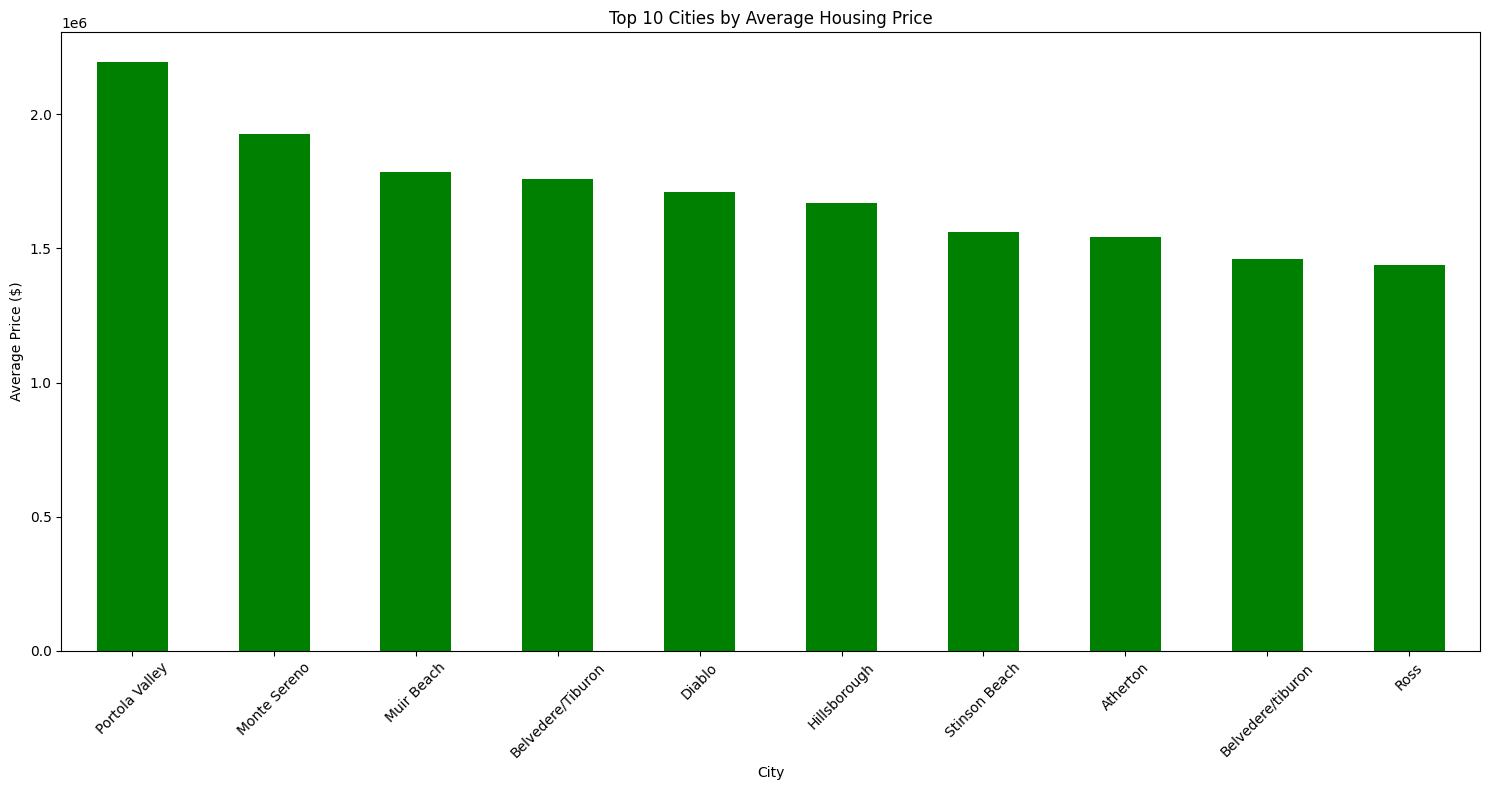

In [ ]:
import matplotlib.pyplot as plt
# Calculate the average housing price for each city
average_prices = housing_data_copy.groupby('city')['price'].mean().sort_values(ascending=False)

# Get the top 10 cities by average price
top_cities = average_prices.head(10)

# Plot the bar chart
plt.figure(figsize=(15, 8))
top_cities.plot(kind='bar', color='green')
plt.title('Top 10 Cities by Average Housing Price')
plt.xlabel('City')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

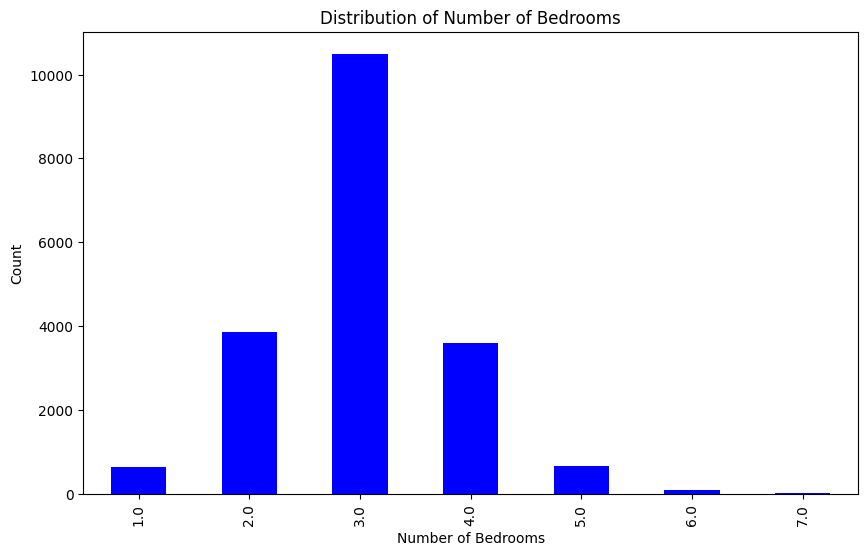

In [ ]:
# Let's create a histogram showing the distribution of the number of bedrooms.

# Plot the histogram for the 'br' column
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
housing_data_copy['br'].value_counts().sort_index().plot(kind='bar', color='blue')
plt.title('Distribution of Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')
plt.show()


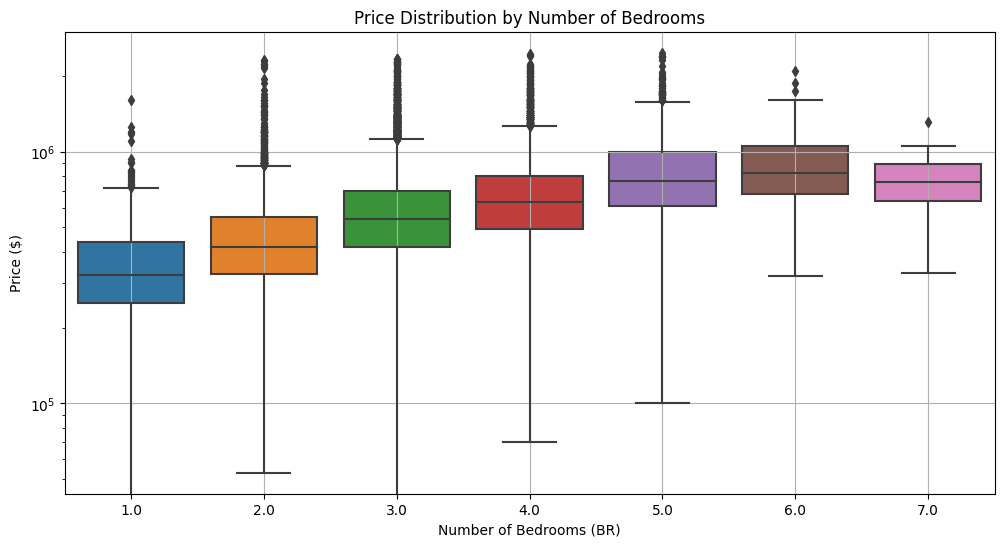

In [ ]:
# Now let's create the box plot
import seaborn as sns
plt.figure(figsize=(12, 6))  # Figure size can be adjusted as needed
sns.boxplot(x='br', y='price', data=housing_data_copy)
plt.title('Price Distribution by Number of Bedrooms')
plt.xlabel('Number of Bedrooms (BR)')
plt.ylabel('Price ($)')
plt.yscale('log')  # Set log scale due to wide range of prices
plt.grid(True)  # Optional: Adds grid for better readability

# Show the plot
plt.show()

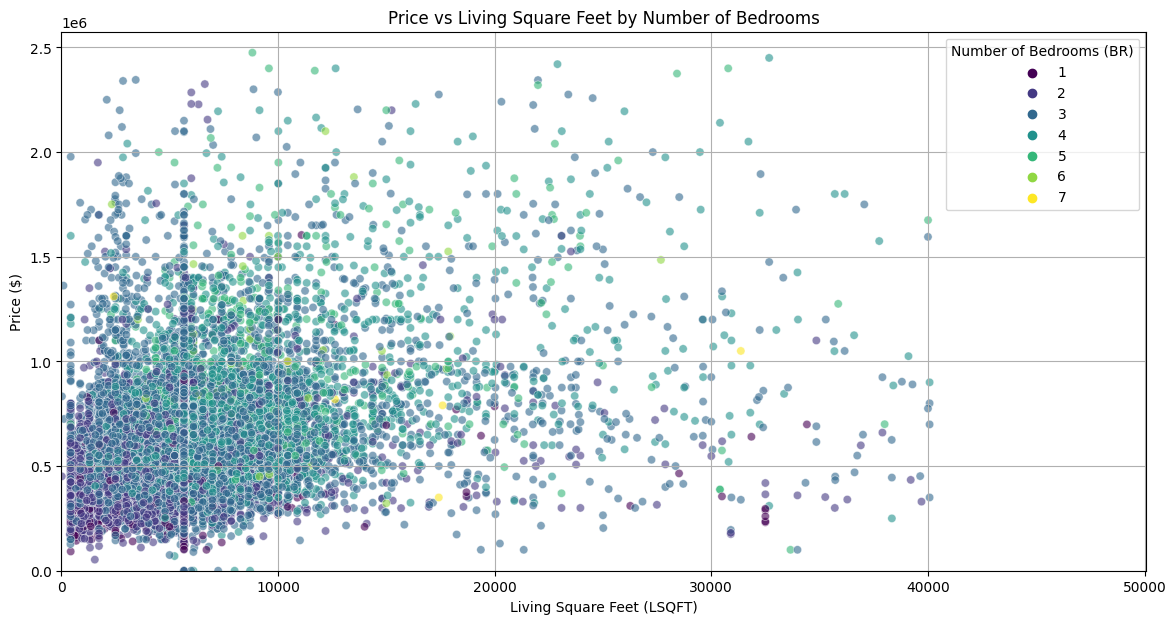

In [ ]:
# Create a scatter plot of price vs living square feet by number of bedrooms
plt.figure(figsize=(14, 7))

# Using seaborn to create a scatter plot and color by number of bedrooms ('br')
sns.scatterplot(data=housing_data_copy, x='lsqft', y='price', hue='br', palette='viridis', alpha=0.6)

plt.title('Price vs Living Square Feet by Number of Bedrooms')
plt.xlabel('Living Square Feet (LSQFT)')
plt.ylabel('Price ($)')

# Set the scale of the axes.
plt.xscale('linear')
plt.yscale('linear')

# Set the limits of the axes.
plt.xlim(0, housing_data_copy['lsqft'].max() + 10000)
plt.ylim(0, housing_data_copy['price'].max() + 100000)

plt.legend(title='Number of Bedrooms (BR)')
plt.grid(True)
plt.show()

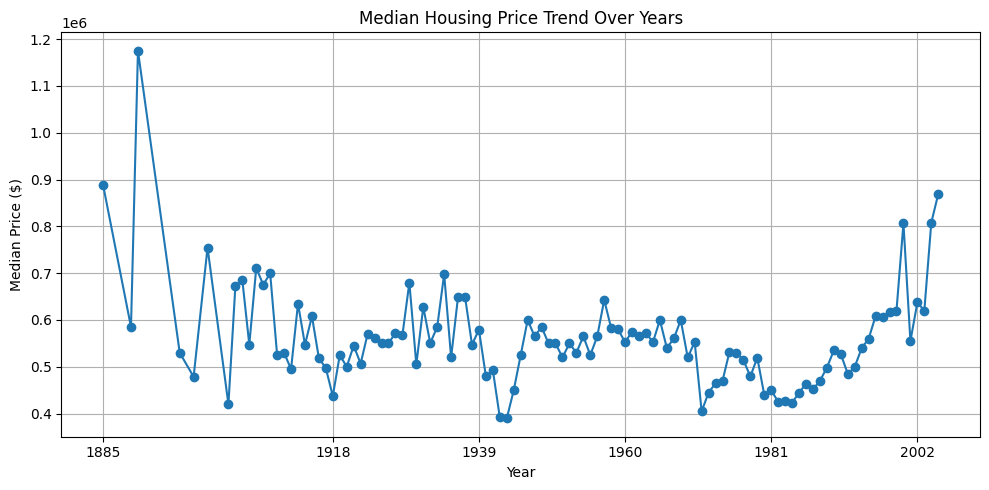

In [ ]:
# Ensure the 'year' column is in the correct format and remove any invalid years if necessary
housing_data_copy = housing_data_copy[housing_data_copy['year'].between(1800, 2020)]
housing_data_copy['year'] = housing_data_copy['year'].astype(int)

# Calculate the median housing price per year
median_price_per_year = housing_data_copy.groupby('year')['price'].median()

# Plot
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.plot(median_price_per_year.index, median_price_per_year.values, marker='o')

plt.title('Median Housing Price Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Median Price ($)')

# Set x-ticks to be spaced out to avoid overlapping
years = median_price_per_year.index.unique()
plt.xticks(years[::max(1, len(years) // 5)])  # Show every nth label to avoid overlap

plt.grid(True)  # Adding a grid for better readability
plt.tight_layout()  # Adjust layout
plt.show()

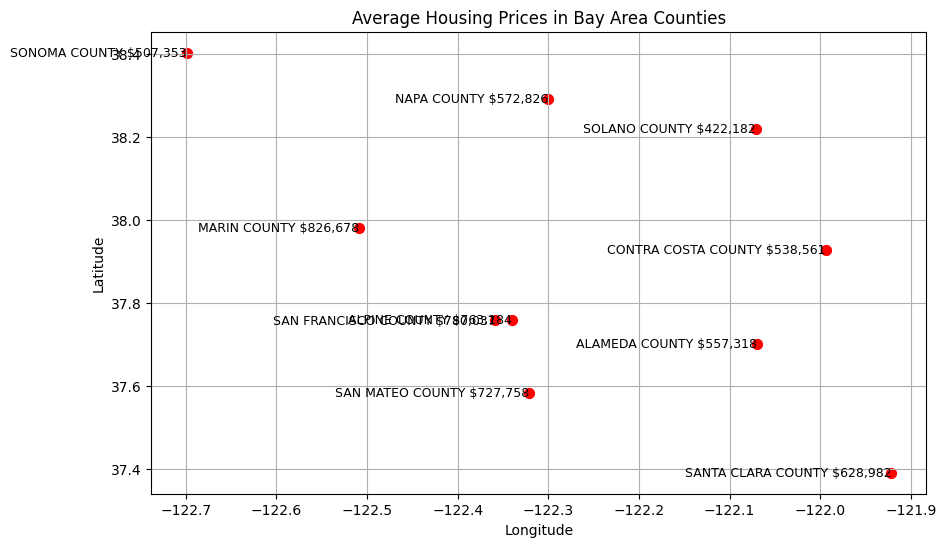

In [ ]:
# Custom function to normalize county names
def normalize_county_name(county):
    normalized_county = county.upper()  # Convert to uppercase for uniformity
    if 'SAN FRANCISCO' in normalized_county:
        return 'SAN FRANCISCO COUNTY'
    return normalized_county


# Apply the normalization function to the 'county' column
housing_data_copy['county'] = housing_data_copy['county'].apply(normalize_county_name)

average_prices = housing_data_copy.groupby('county').agg(
    latitude=('lat', 'mean'),
    longitude=('long', 'mean'),
    price=('price', 'mean')
).reset_index()

# Now, let's plot the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot for each city
for index, row in average_prices.iterrows():
    plt.scatter(row['longitude'], row['latitude'], color='red', s=50)
    plt.text(row['longitude'], row['latitude'], f"{row['county']} ${int(row['price']):,}",
             fontsize=9, ha='right', va='center')

plt.title('Average Housing Prices in Bay Area Counties')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

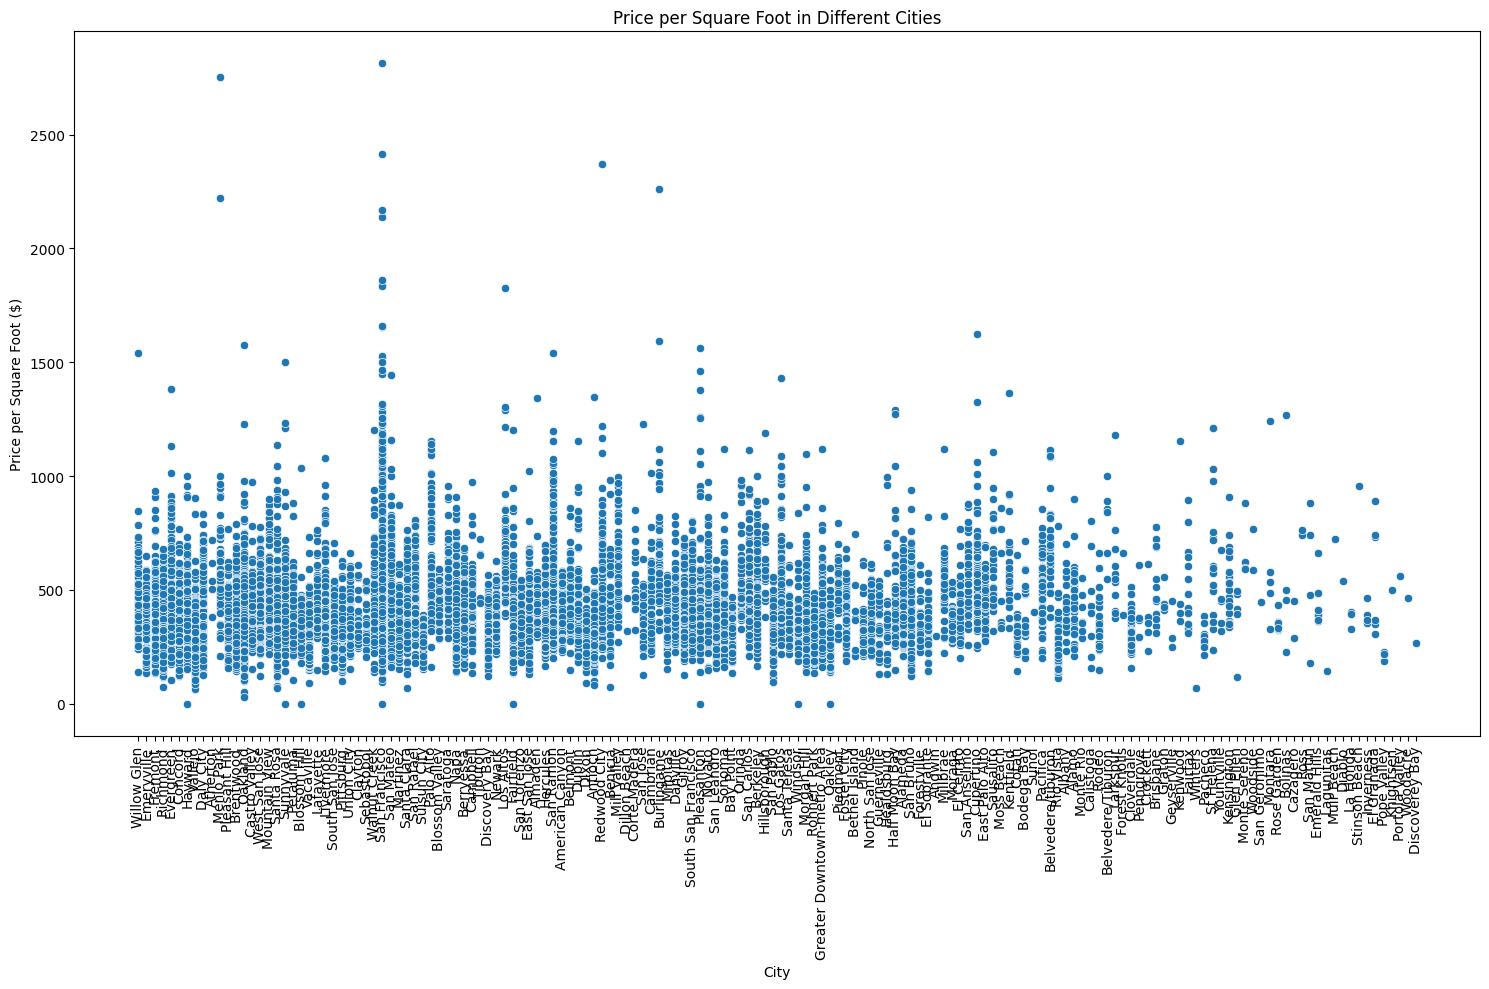

In [ ]:
# Calculate the price per square foot
housing_data_copy['price_per_sqft'] = housing_data_copy['price'] / housing_data_copy['bsqft']

# Now we'll filter out any infinite or NaN values that may have resulted from division by zero or NaN square footage
housing_data_copy = housing_data_copy[(housing_data_copy['price_per_sqft'] != float('inf')) & housing_data_copy['price_per_sqft'].notna()]

# Create a scatter plot
plt.figure(figsize=(15, 10))
sns.scatterplot(x='city', y='price_per_sqft', data=housing_data_copy)

plt.title('Price per Square Foot in Different Cities')
plt.xlabel('City')
plt.ylabel('Price per Square Foot ($)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

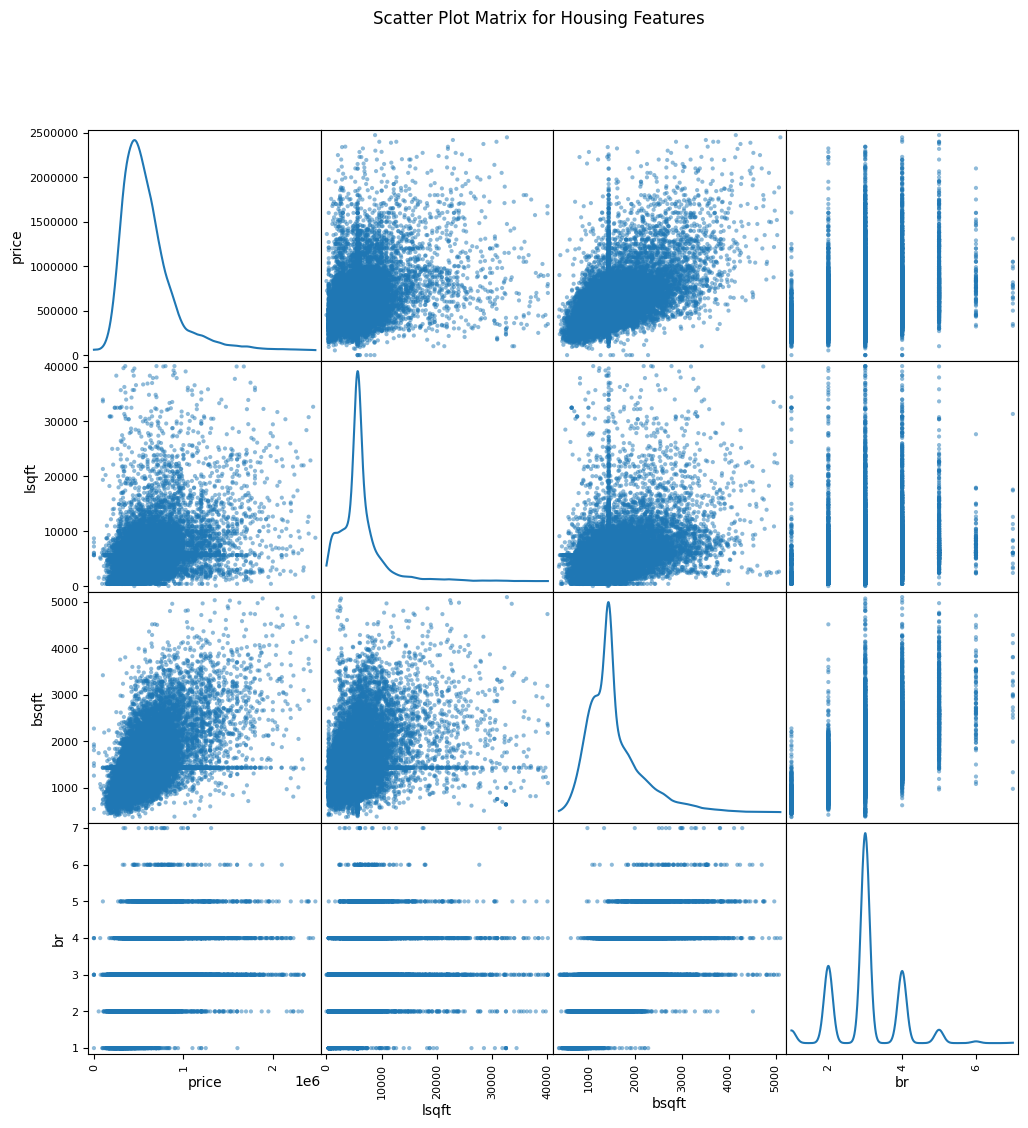

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Assuming housing_clean is your cleaned DataFrame with relevant columns
# You may need to adjust column names as per your actual DataFrame

# Generate the scatter plot matrix
scatter_matrix(housing_data_copy[['price', 'lsqft', 'bsqft', 'br']], figsize=(12, 12), diagonal='kde')

# Show the plot
plt.suptitle('Scatter Plot Matrix for Housing Features')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd




# Selecting features - excluding categorical and target variable
features = housing_data.select_dtypes(include=[np.number]).drop(columns='price')

# Target variable
target = housing_data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Train Linear Regression model
linear_model.fit(X_train_scaled, y_train)
linear_pred = linear_model.predict(X_test_scaled)
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_pred))

# Train Random Forest model
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

# Train XGBoost model
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

# Print out the RMSE for each model
print('Linear Regression RMSE:', linear_rmse)
print('Random Forest RMSE:', rf_rmse)
print('XGBoost RMSE:', xgb_rmse)
'''
# Calculate the mean and range of the target variable
mean_price = np.mean(target)
range_price = np.max(target) - np.min(target)

# Calculate NRMSE by dividing the RMSE by the mean or range
nrmse_linear_mean = linear_rmse / mean_price
nrmse_rf_mean = rf_rmse / mean_price
nrmse_xgb_mean = xgb_rmse / mean_price

nrmse_linear_range = linear_rmse / range_price
nrmse_rf_range = rf_rmse / range_price
nrmse_xgb_range = xgb_rmse / range_price

# Print out the NRMSE as a percentage
print('Linear Regression NRMSE (mean): {:.2%}'.format(nrmse_linear_mean))
print('Random Forest NRMSE (mean): {:.2%}'.format(nrmse_rf_mean))
print('XGBoost NRMSE (mean): {:.2%}'.format(nrmse_xgb_mean))

print('Linear Regression NRMSE (range): {:.2%}'.format(nrmse_linear_range))
print('Random Forest NRMSE (range): {:.2%}'.format(nrmse_rf_range))
print('XGBoost NRMSE (range): {:.2%}'.format(nrmse_xgb_range))
'''

Linear Regression RMSE: 206180.4472651777
Random Forest RMSE: 161406.0571429672
XGBoost RMSE: 160817.84693783405


"\n# Calculate the mean and range of the target variable\nmean_price = np.mean(target)\nrange_price = np.max(target) - np.min(target)\n\n# Calculate NRMSE by dividing the RMSE by the mean or range\nnrmse_linear_mean = linear_rmse / mean_price\nnrmse_rf_mean = rf_rmse / mean_price\nnrmse_xgb_mean = xgb_rmse / mean_price\n\nnrmse_linear_range = linear_rmse / range_price\nnrmse_rf_range = rf_rmse / range_price\nnrmse_xgb_range = xgb_rmse / range_price\n\n# Print out the NRMSE as a percentage\nprint('Linear Regression NRMSE (mean): {:.2%}'.format(nrmse_linear_mean))\nprint('Random Forest NRMSE (mean): {:.2%}'.format(nrmse_rf_mean))\nprint('XGBoost NRMSE (mean): {:.2%}'.format(nrmse_xgb_mean))\n\nprint('Linear Regression NRMSE (range): {:.2%}'.format(nrmse_linear_range))\nprint('Random Forest NRMSE (range): {:.2%}'.format(nrmse_rf_range))\nprint('XGBoost NRMSE (range): {:.2%}'.format(nrmse_xgb_range))\n"

In [ ]:
from sklearn.metrics import r2_score
# Calculate R-squared for each model
r2_linear = r2_score(y_test, linear_pred)
r2_rf = r2_score(y_test, rf_pred)
r2_xgb = r2_score(y_test, xgb_pred)

# Print out the R-squared for each model
print('Linear Regression R-squared:', r2_linear)
print('Random Forest R-squared:', r2_rf)
print('XGBoost R-squared:', r2_xgb)

Linear Regression R-squared: 0.4772803177313599
Random Forest R-squared: 0.6796582412818284
XGBoost R-squared: 0.6819888223198467


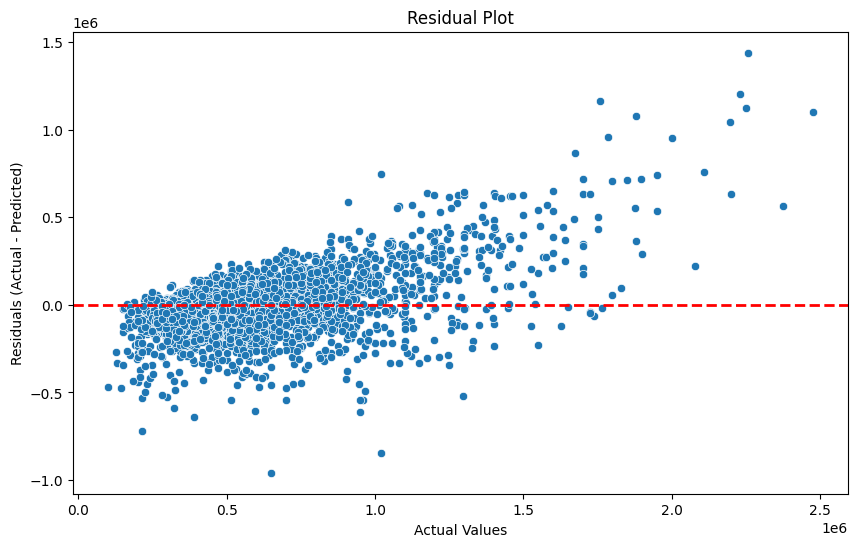

In [ ]:
#rf_pred
residuals = y_test - rf_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

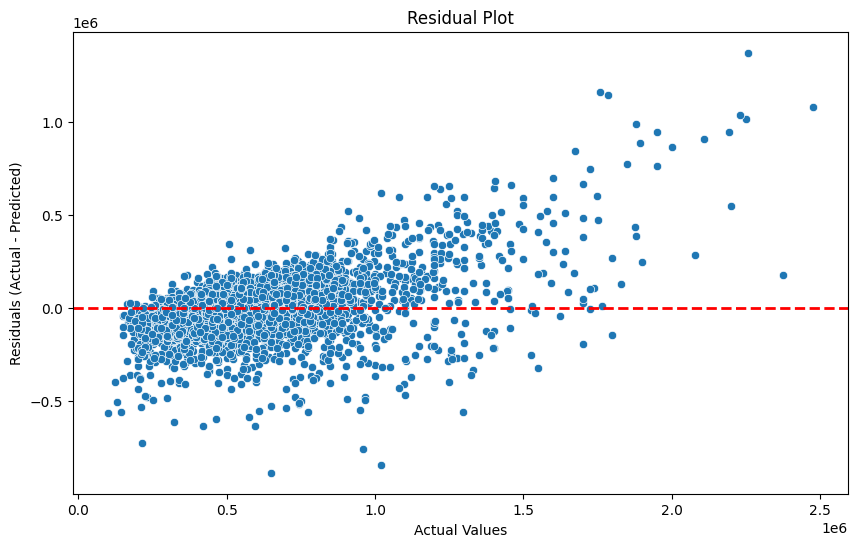

In [ ]:
#xgb_pred
residuals = y_test - xgb_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

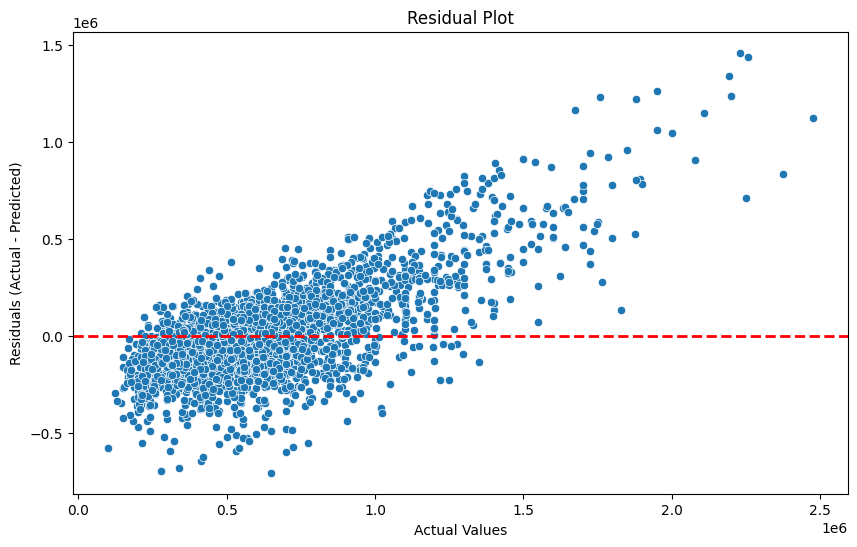

In [ ]:
#linear_pred
residuals = y_test - linear_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 20, 50, 75,100, 200, 300, 500,750,1000],
    'max_depth': [1, 2, 3, 5, 7, 9,11],
    'learning_rate': [0.01, 0.05, 0.1, 0.001,0.0001],
    # You can add more parameters here
}

# Initialize the XGBoost regressor
xgb_reg = XGBRegressor(random_state=42)

# Setup the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_grid,
                               cv=4, n_iter=25, scoring='r2', n_jobs=-1, verbose=1,
                               random_state=42)

# Fit the random search model
random_cv.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding R-squared
print("Best parameters found: ", random_cv.best_params_)
print("Best R-squared found: ", random_cv.best_score_)


Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters found:  {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}
Best R-squared found:  0.678527888730199


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32)

# Predict and evaluate
nn_pred = model.predict(X_test_scaled)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_pred.flatten()))
nn_r2 = r2_score(y_test, nn_pred.flatten())

print('Neural Network RMSE:', nn_rmse)
print('Neural Network R-squared:', nn_r2)


Epoch 1/50
388/388 [==============================] - 3s 3ms/step - loss: 432603201536.0000 - val_loss: 426358996992.0000
Epoch 2/50
388/388 [==============================] - 1s 3ms/step - loss: 419895508992.0000 - val_loss: 400464740352.0000
Epoch 3/50
388/388 [==============================] - 1s 3ms/step - loss: 378733985792.0000 - val_loss: 341190246400.0000
Epoch 4/50
388/388 [==============================] - 1s 4ms/step - loss: 307640074240.0000 - val_loss: 257897611264.0000
Epoch 5/50
388/388 [==============================] - 2s 4ms/step - loss: 224393609216.0000 - val_loss: 174477328384.0000
Epoch 6/50
388/388 [==============================] - 2s 4ms/step - loss: 152393940992.0000 - val_loss: 114557255680.0000
Epoch 7/50
388/388 [==============================] - 1s 3ms/step - loss: 106386948096.0000 - val_loss: 81199972352.0000
Epoch 8/50
388/388 [==============================] - 1s 3ms/step - loss: 81780375552.0000 - val_loss: 64666210304.0000
Epoch 9/50
388/388 [=======

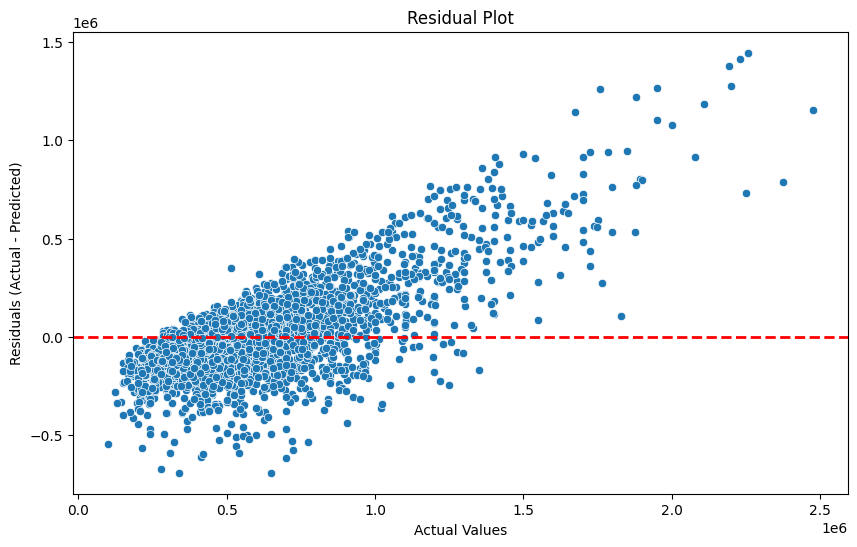

In [ ]:
nn_pred = nn_pred.flatten()
residuals = y_test - nn_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

In [ ]:
from sklearn.svm import SVR
import math

# Initialize the Support Vector Regression (SVR) model
svr_model = SVR(kernel='linear')  # You can experiment with different kernels (linear, rbf, poly, etc.)

# Train the model using standardized features
svr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_svm = svr_model.predict(X_test_scaled)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred_svm)
print(f'Root Mean Squared Error (SVR): {math.sqrt(mse)}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred_svm)
print(f'R-squared: {r2}')

Root Mean Squared Error (SVR): 284909.4361379246
R-squared: 0.0018689525568740262


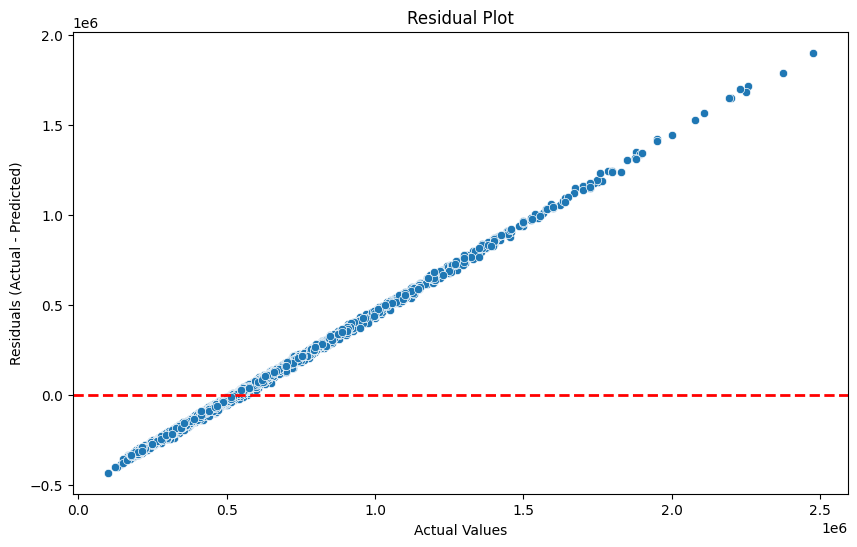

In [ ]:
#y_pred_svm
residuals = y_test - y_pred_svm
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

gb_model = ensemble.GradientBoostingRegressor()
gb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred_gb)
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred_gb)
print(f'R-squared: {r2}')

Root Mean Squared Error: 178170.05884007385
R-squared: 0.6096597416841114


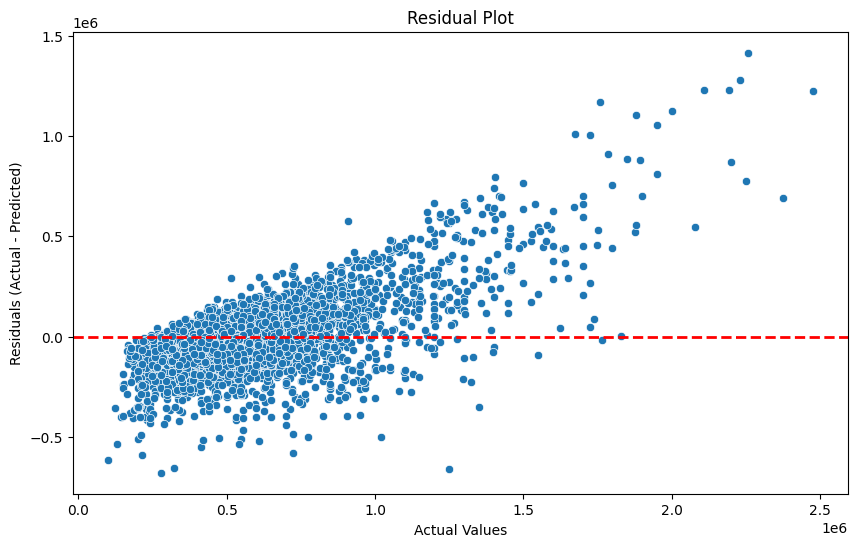

In [ ]:
#y_pred_gb
residuals = y_test - y_pred_gb
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()